## Task 4: Explainability through Grad-CAM

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib as mpl
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
# from tensorflow.keras import Input, Model
# import math
from tensorflow.keras.preprocessing import image

from funcs_Task1 import training_data_Pipeline, test_validation_data_Pipeline, get_normalization_numbers
# from funcs_Task2_3 import concat_generators

In [3]:
import pathlib
package_root = pathlib.Path()
data_root = package_root.absolute().parent.parent / 'covid xray'

#subdirectories
train_dir = data_root / 'train'
val_dir = data_root / 'val'
test_dir = data_root / 'test'

# constants
img_size = (128, 128)

# Get normalization parameters from the training set
global_mean, global_std = get_normalization_numbers(img_size, train_dir)

Found 1600 images belonging to 2 classes.


### 1. Grad-CAM implementation

In [4]:
# function to preprocess image
def preprocess_specific_image(img_path, img_size, global_mean, global_std ):
    # Load the specific image
    img = image.load_img(img_path, target_size=img_size)

    # Convert the image to an array
    img_array = image.img_to_array(img)

    # Expand dimensions to match the batch format expected by the model
    img_array = np.expand_dims(img_array, axis=0)

    # Apply normalization
    img_array = (img_array / 255.0 - global_mean) / global_std

    return tf.convert_to_tensor(img_array)

In [ ]:
# Load model and remove final activation (sigmoid)
model = load_model("covid_xray_baseline_model.keras")
model.layers[-1].activation = None

# select test sample and preprocess
img_path = data_root / "test/NORMAL/NORMAL-2100.png"
img_array = preprocess_specific_image(img_path, img_size, global_mean, global_std )

In [39]:
[i.name for i in model.layers]

['input_layer_3',
 'conv2d_6',
 'max_pooling2d_6',
 'batch_normalization_3',
 'conv2d_7',
 'max_pooling2d_7',
 'flatten_3',
 'dense_6',
 'dropout_3',
 'dense_7']

In [37]:
model.layers[-6].name

'conv2d_7'

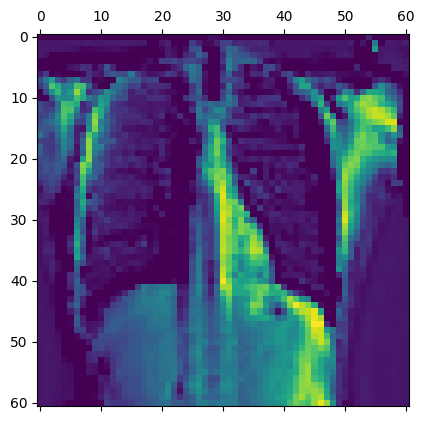

In [57]:
# function getting heatmap for Grad-CAM
def make_gradcam_heatmap(img_array, model, target_layer_name, class_pred = 1):

    target_layer = model.get_layer(target_layer_name) 

    feature_extractor = keras.models.Model(
        inputs= model.input,
        outputs=[target_layer.output, model.output]
    )

    # Forward and backward passes
    with tf.GradientTape() as tape:
        # Evaluate and extract convolutional layer's output
        conv_outputs, preds = feature_extractor(img_array)
        tape.watch(conv_outputs)
        
        # adapt for binary classification with only one class output
        if class_pred == 1:
            class_channel = preds[:, 0]
        if class_pred == 0:
            class_channel = -preds[:, 0]  # Complement of the scalar output

    # compute the gradients and average among channel dimenstions
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # get heatmap
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    #normalization between 0 and 1
    if tf.math.reduce_max(heatmap) != 0:
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array,
    model,
    target_layer_name=model.layers[-6].name,
    class_pred= 0
)

plt.matshow(heatmap)


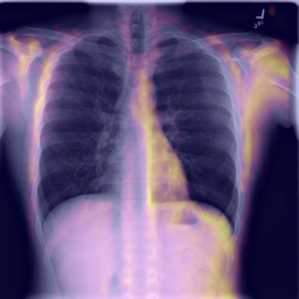

In [58]:
# function overlaying heatmap on original picture
def get_gradcam_image(img_path, heatmap, alpha=0.4, threshold=0.4, cmap='jet'):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.maximum(heatmap, threshold)
    heatmap = (heatmap - threshold) / (heatmap.max() - threshold + 1e-8)  # Normalize after thresholding

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps[cmap]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    return(superimposed_img)

get_gradcam_image(img_path, heatmap, threshold=0.1, cmap='plasma')

### 2. Explaining the decision with Grad-CAM

In [19]:
## divide test data into groups
# gather necessary data
test_data_gen = test_validation_data_Pipeline(200, img_size, train_dir, test_dir, shuffle = False)
y_pred_probs = model.predict(test_data_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_data_gen.classes

filepaths = test_data_gen.filepaths
class_indices = test_data_gen.class_indices

# save filepaths of images in 4 classes, based on right or wrong classification and true value
y_pred_covid = (y_pred == class_indices["COVID"])
y_true_covid = (y_true == class_indices["COVID"])

Covid_misclassified = [filepaths[i] for i in range(len(filepaths)) if y_true_covid[i] & ~y_pred_covid[i]]
Covid_correctclassified = [filepaths[i] for i in range(len(filepaths))  if y_true_covid[i] & y_pred_covid[i]]
normal_misclassified = [filepaths[i] for i in range(len(filepaths))  if ~y_true_covid[i] & y_pred_covid[i]]
normal_correctclassified = [filepaths[i] for i in range(len(filepaths))  if ~y_true_covid[i] & ~y_pred_covid[i]]


Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


c:\Users\friev\OneDrive - UGent\MaStat\Big Data Science\Artificial Intelligence\exercises\project\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step


In [44]:
# sanity check classes
len(Covid_misclassified)+len(Covid_correctclassified)+len(normal_correctclassified)+len(normal_misclassified)

200

In [63]:
# function plotting some images with grad-cam
def show_some_gradcams_from_list(list, img_size, model, class_pred, global_mean, global_std, start_index = 0, stop_index = 5 ):
    plt.figure(figsize=(15, 6))
    for i, img_path in enumerate(list[start_index:stop_index]):
        # make gradcam image
        img_array = preprocess_specific_image(img_path, img_size, global_mean, global_std )
        heatmap = make_gradcam_heatmap(img_array, model, target_layer_name=model.layers[-6].name, class_pred=class_pred)
        img = get_gradcam_image(img_path, heatmap, threshold = 0.1, cmap = 'plasma')

        # plot gradcam image
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

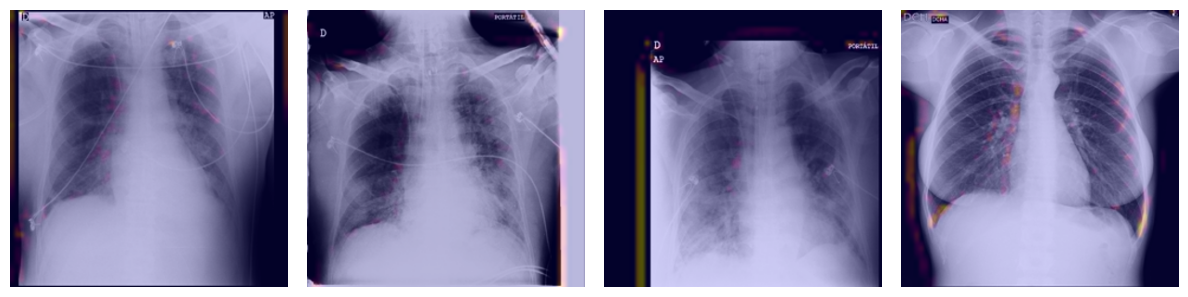

In [64]:
#Covid cases that are misclassified by the model as normal
show_some_gradcams_from_list(
    Covid_misclassified, img_size, model,
    global_mean = global_mean, global_std=global_std , 
    start_index = 0, stop_index = 5, class_pred= class_indices["NORMAL"]
    )

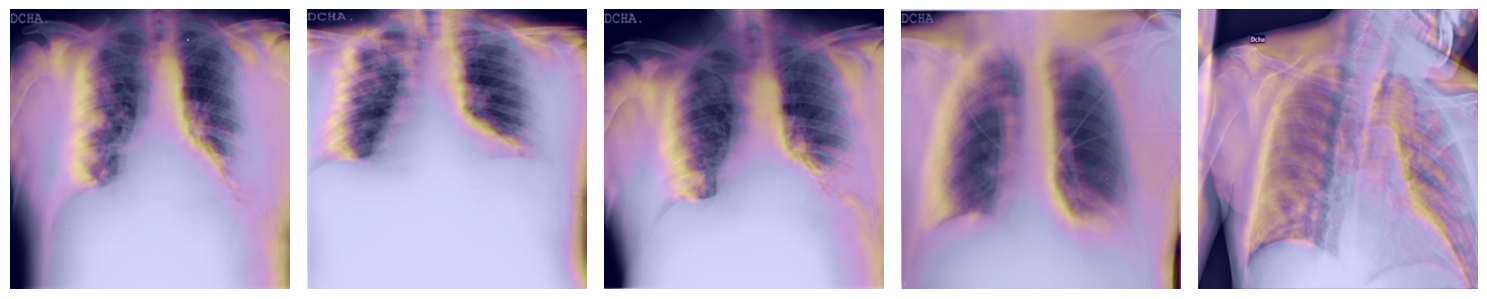

In [65]:
#Covid cases that are correctly classified by the model 
show_some_gradcams_from_list(
    Covid_correctclassified, img_size, model, 
    global_mean = global_mean, global_std=global_std , 
    start_index =3, stop_index = 8, class_pred= class_indices["COVID"]
)

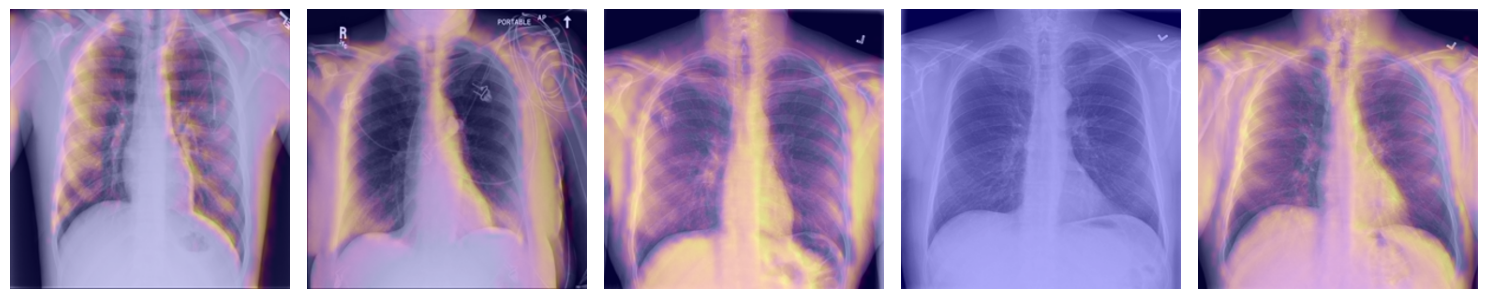

In [66]:
#normal cases that are incorrectly classified by the model as covid cases
show_some_gradcams_from_list(
    normal_misclassified, img_size, model, 
    global_mean = global_mean, global_std=global_std , 
    start_index = 25, stop_index = 30, class_pred=  class_indices["COVID"]
)


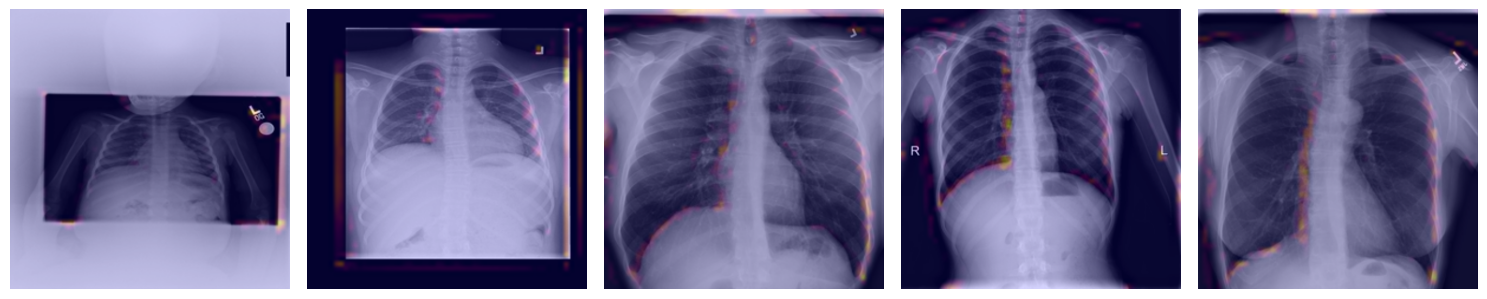

In [67]:
#normal cases that are correctly classified by the model
show_some_gradcams_from_list(
    normal_correctclassified, img_size, model, 
    global_mean = global_mean, global_std=global_std , 
    start_index = 0, stop_index = 5, class_pred=  class_indices["NORMAL"] 
)